In [108]:
import matplotlib.pyplot as plt

def numify(s):
    try:
        return float(s)
    except ValueError:
        return s

In [109]:
data = {}
with open('./HAs.csv') as ha_file:
    header = ha_file.readline().rstrip()
    categories = header.split('\t')
    ind2cat = {ii:cat.replace('"','') for ii, cat in enumerate(categories)}
    for line in ha_file:
        line = [tok.replace('"','') for tok in line.rstrip().split('\t')]
    
        
        data[line[0]] = {ind2cat[ii]:numify(tok) for ii, tok in enumerate(line)}


{'name': 'SMB', 'Publisher': 'Nintendo', 'Developer': 'Nintendo', 'ReleaseDate-US': '10/31/85', 'Date Number': '10/31/85', 'Month': 10.0, 'Day ': 31.0, 'Year': 1985.0, 'minHoldDuration': 1.0, 'maxHoldDuration': 32.0, 'down_reset': 1.5375, 'down_mult': 0.0, 'down_gravity': 0.1875, 'up-control_reset': -4.1, 'up-control_gravity': 0.1333333333, 'up-fixed_reset': -0.099832279, 'up-fixed_mult': 0.8499673876, 'up-fixed_gravity': 0.3998695503, 'ground_reset': 0.0, 'ground_mult': 0.0, 'ground_gravity': 0.0}
1.0
-3.9666666667000055 Before
-3.4713695831750035
Descent 0.0008310119300082523
0.0008310119300082523


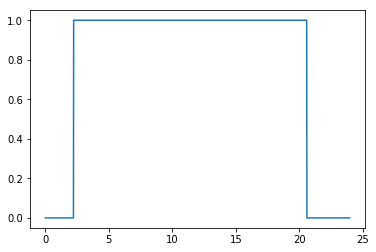

7.19999999999
-3.1400000002400414 Before
-2.7687298762680275
Descent 0.0036990058119718092
0.0036990058119718092


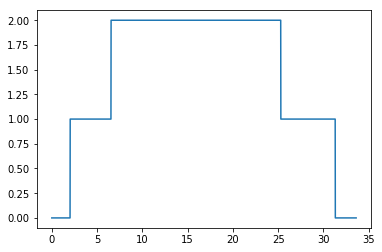

13.39999999998
-2.3133333337800774 Before
-2.0660901693610514
Descent 0.006566999693935274
0.006566999693935274


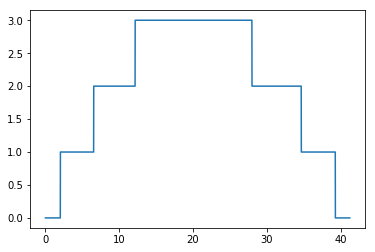

19.599999999970002
-1.4866666673201134 Before
-1.363450462454075
Descent 0.00277050107092037
0.00277050107092037


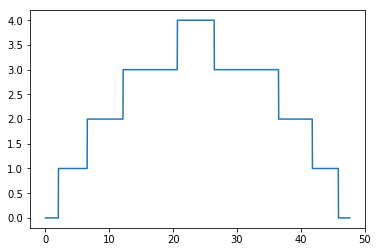

25.79999999996
-0.6600000008601324 Before
-0.6608107555470846
Descent 0.005638494952916032
0.005638494952916032


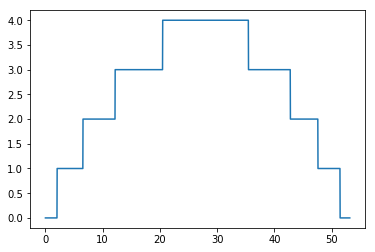

31.99999999995
0.1666666655998692 Before
0.04182895135992362
Descent 0.04182895135992362
0.04182895135992362


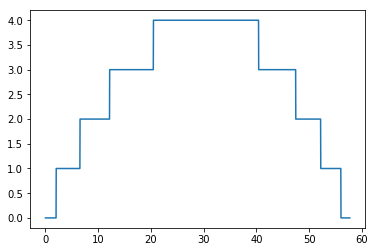

[[0.]
 [0.]
 [0.]
 ...
 [5.]
 [5.]
 [5.]]
(7493, 1) (7493, 2)
[ 1.4170053  -0.11702511] [205.2132391  -61.18288935]


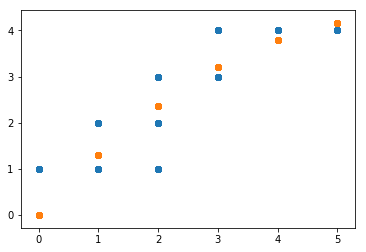

(7955, 1)
(7955, 1)
[-0.21612812] [-325.78767088]


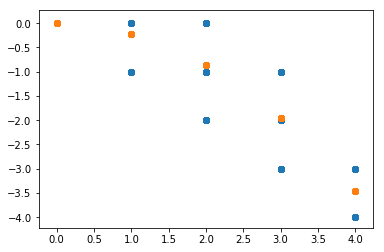

In [196]:
import numpy as np

model = data['SMB']
print(model)
dt = 1.0/60.0
tilesize = 16
jumps = []
falls = []


for duration in np.arange(model['minHoldDuration'],model['maxHoldDuration'],(model['maxHoldDuration']-model['minHoldDuration'])/5.0-0.00000000001):
#for duration in [model['maxHoldDuration']]:
    ys = []
    y = 0
    vy = model['up-control_reset']
    ts = []
    t = 0
    print(duration)
    jump = []
    jumps.append(jump)
    fall = []
    falls.append(fall)
    for _ in np.arange(0,duration,dt):
        ys.append(y)
        ts.append(t)
        t += dt
        y -= vy*dt
        vy += model['up-control_gravity']*dt
        jump.append(y)
    descent = False
    print(vy,'Before')
    vy = model['up-fixed_reset']+vy*model['up-fixed_mult']
    print(vy)
    current = jump
    while y > 0:
        ys.append(y)
        ts.append(t)
        if vy >= 0.0 and not descent:
            descent = True
            print('Descent',vy)
            #vy = model['down_reset']+vy*model['down_mult']
            current = fall
            print(vy)
        t += dt
        y -= vy*dt
        current.append(y)
        if descent or model['up-fixed_gravity'] == 0.0:
            vy += model['down_gravity']*dt
        else:
            vy += model['up-fixed_gravity']*dt
            
        
    plt.plot(ts,np.round(np.array(ys)/tilesize))
    plt.show()



jumps = [np.round(np.array(jump)/tilesize) for jump in jumps]
falls = [np.round(np.array(jump)/tilesize) for jump in falls]

merged_jumps = np.vstack([j.reshape(-1,1) for j in jumps])
merged_jumps_t = np.vstack([np.array(range(len(j))).reshape(-1,1) for j in jumps])*16.0*10.0/60.0/60.0

merged_jumps_x = np.round(np.array(merged_jumps_t)/tilesize)
print(merged_jumps_x)


merged_falls = np.vstack([j.reshape(-1,1) for j in falls])
merged_falls_t = np.vstack([np.array(range(len(j))).reshape(-1,1) for j in falls])*16.0*10.0/60.0/60.0
merged_falls_x = np.round(np.array(merged_falls_t)/tilesize)

jump_data = []
for snippet in jumps:
    path = np.array(snippet)
    path[:] -= path[0]
    jump_data.append(path.reshape(-1,1))
    
    

jump_Y = np.vstack(jump_data)
jump_X = np.hstack([merged_jumps_x,merged_jumps_x**2])
print(jump_Y.shape,jump_X.shape)
jump_model = sm.OLS(jump_Y,jump_X)
jump_results = jump_model.fit()
print(jump_results.params,jump_results.tvalues)
plt.scatter(jump_X[:,0],jump_Y)
plt.scatter(jump_X[:,0],np.dot(jump_X,jump_results.params))
plt.show()

fall_data = []
for snippet in falls:
    path = np.array(snippet)
    path[:] -= path[0]
    fall_data.append(path.reshape(-1,1))
fall_Y = np.vstack(fall_data)
print(fall_Y.shape)
fall_X = merged_falls_x.reshape([-1,1])**2
print(fall_X.shape)

fall_model = sm.OLS(fall_Y,fall_X)
fall_results = fall_model.fit()
print(fall_results.params,fall_results.tvalues)
plt.scatter(merged_falls_x,fall_Y)
plt.scatter(merged_falls_x,np.dot(fall_X,fall_results.params))
plt.show()

[[0.]
 [0.]
 [0.]
 ...
 [4.]
 [4.]
 [4.]]
